Virtual Acoustics and Immersive Audio Workshop - CCRMA Stanford University  
21.07.25 - Orchisama Das, Gloria Dal Santo
  
### L01: Acoustic Parameters 

In this assignment we will 
- Compute the Energy Decay Curve (EDC) and Energy Decay Relief (EDR) of a given measured RIR 
- Estimate the reverberation time (T60) from the EDC 
- Compute the Normalized Echo Density



In [1]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from pathlib import Path

from utils import (
    audioread, 
    filterbank, 
    find_onset)
from room_acoustics.analysis import (
    compute_edc, 
    estimate_rt60,
    compute_edr, 
    normalized_echo_density)
from room_acoustics.plot import (
    plot_time_domain)

#### 1. Load Impulse Response

We will be using two impulse responses present in the `data/.` folder: `s3_r4_o.wav` and `P_103_Speaker.wav`.  
- 1.1 Load the signals and their sampling frequency using the `audioread` function.  
- 1.2 Plot their time domain response and use the `ipd` library to add a widget to play the sound.

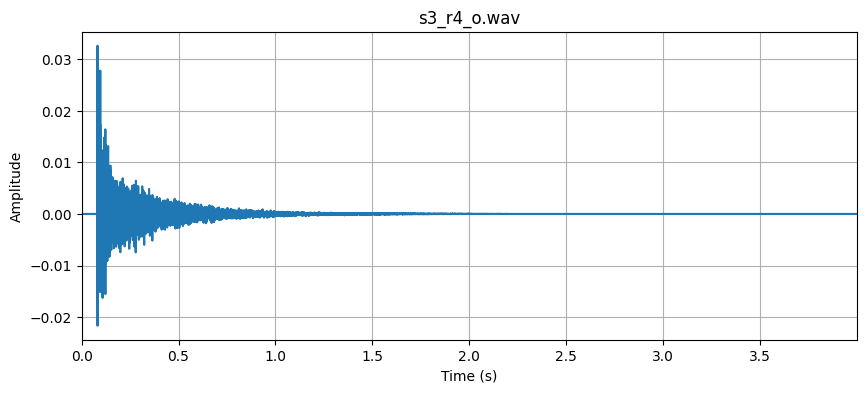

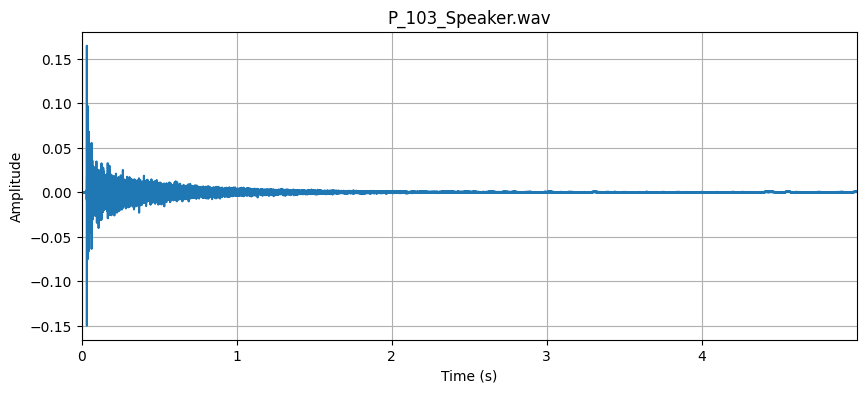

In [2]:
# --- Load Impulse Responses ---
rir_path = Path('..') / 'data' / 's3_r4_o.wav'
rir_1, fs_1 = audioread(str(rir_path))
ipd.display(ipd.Audio(rir_1, rate=fs_1))
plot_time_domain(rir_1, fs_1, 's3_r4_o.wav')

rir_path = Path('..') / 'data' / 'P_103_Speaker.wav'
rir_2, fs_2 = audioread(str(rir_path))
ipd.display(ipd.Audio(rir_2, rate=fs_2))
plot_time_domain(rir_2, fs_2, 'P_103_Speaker.wav')

#### 2 Compute the EDC and Estimate RT 
For `s3_r4_o.wav` do the following: 
- 2.1 Complete the functions in `room_acoustics.analysis` for the computation of the EDC via Schroeder backward integration (e.g. `schroeder_backward_int` and `compute_edc`).  
- 2.2 Define a dB range you will use to estimate the RT.  
- 2.3 Use `scipy.stats.linregress`to estimate the RT via least squares regression. You can do this in the function called `estimate_rt60`. 
- 2.4 Plot the EDC and the linear fit. 


/Users/dalsag1/Aalto Dropbox/Gloria Dal Santo/aalto/workshop/vaia-25/lectures/git/VAIAWorkshop25Public/src/room_acoustics/analysis.py:109: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


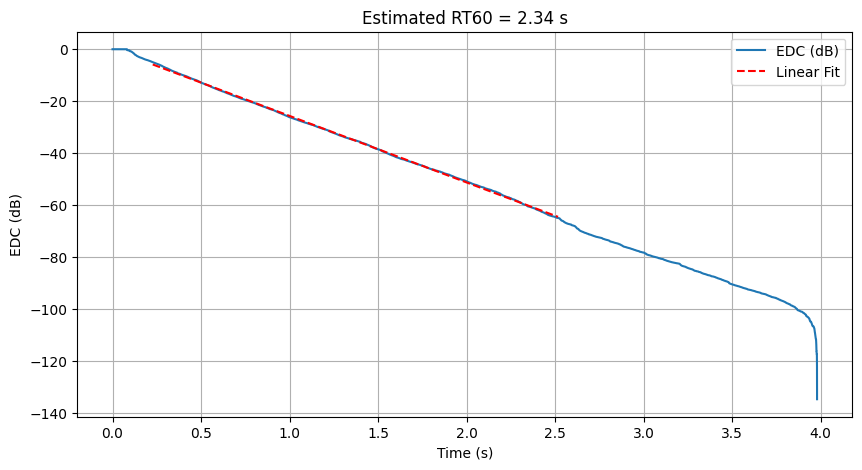

Estimated RT60: 2.34 seconds


In [3]:
# --- Compute EDC and Estimate RT60 ---
# Compute the EDC for the first impulse response
edc_db = compute_edc(rir_1)
# Construct the time vector
time = np.arange(len(edc_db)) / fs_1

# Define the decay start and end dB levels
decay_start_db = -5
decay_end_db = -65
# Estimate the T60 using the defined decay levels
rt60, slope, intercept, valid_range = estimate_rt60(edc_db, time, decay_start_db, decay_end_db)

plt.figure(figsize=(10, 5))
plt.plot(time, edc_db, label="EDC (dB)")
plt.plot(time[valid_range], slope * time[valid_range] + intercept, 'r--', label="Linear Fit")
plt.xlabel("Time (s)")
plt.ylabel("EDC (dB)")
plt.title(f"Estimated RT60 = {rt60:.2f} s")
plt.legend()
plt.grid(True)
# plt.ylim(-80, 10)
plt.show()
print(f"Estimated RT60: {rt60:.2f} seconds")

#### 3 Compute the Frequency Dependent EDC and Estimate RT 
Oftentimes we are more interested in the frequency dependent decay. 
- 3.1 Filter the RIR using the given filterbank function 
- 3.2 Repeat the steps in 2 for all frequency bands 
- 3.3 Plot the RT curve as a function of the frequency

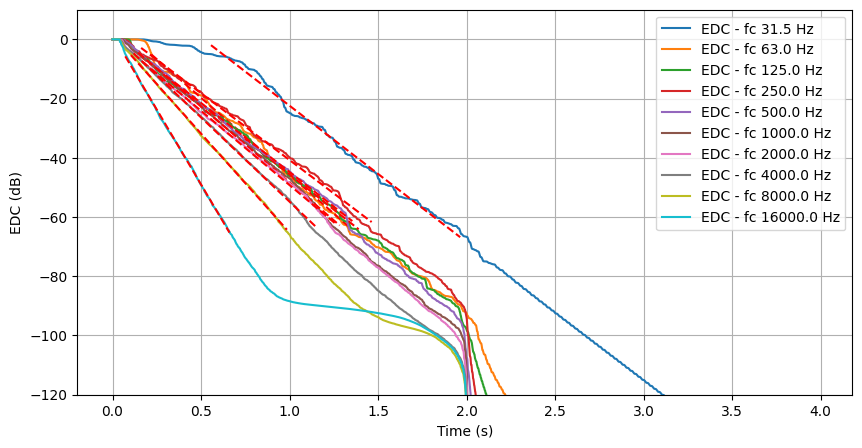

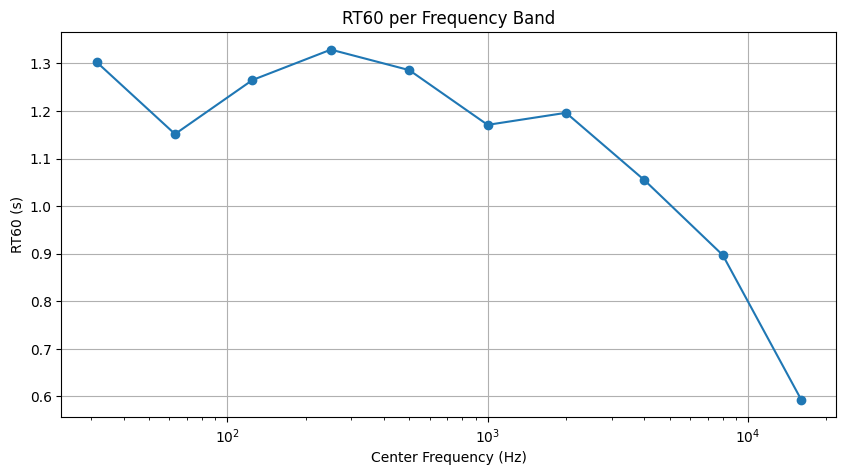

In [4]:
# --- Compute the EDC per frequency band and Estimate RT60 ---
# Convert energy to decibel (dB) scale, adding a small offset to avoid log(0)
rir_1_bands, center_freqs = filterbank(
    rir_1,
    n_fractions=1, 
    f_min=20,
    f_max=20000,
    sample_rate=fs_1,
)

plt.figure(figsize=(10, 5))
rt60_curve = np.zeros(len(center_freqs))
for i_band in range(len(center_freqs)):
    # Compute EDC for the current frequency band
    edc_db_band = compute_edc(rir_1_bands[i_band, :])
    # Construct the time vector for this band
    time = np.arange(len(edc_db_band)) / fs_1
    # Estimate RT60 using the defined decay levels
    rt60, slope, intercept, valid_range = estimate_rt60(edc_db_band, time, decay_start_db, decay_end_db)
    rt60_curve[i_band] = rt60
    plt.plot(time, edc_db_band, label=f"EDC - fc {center_freqs[i_band]} Hz")
    plt.plot(time[valid_range], slope * time[valid_range] + intercept, 'r--')

plt.xlabel("Time (s)")
plt.ylabel("EDC (dB)")
plt.legend()
plt.grid(True)
plt.ylim(-120, 10)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(center_freqs, rt60_curve, marker='o')
plt.ylabel("RT60 (s)")
plt.xlabel("Center Frequency (Hz)")
plt.xscale('log')
plt.title("RT60 per Frequency Band")
plt.grid(True)
plt.show()


#### 4 Compensate the influence of background noise 
The previous RIR was very clean, it had a high signal to noise ratio which allowed us to 
estimate the reverberation time directly from a 60 dB drop in energy.  
In this section you will work with a different RIR, which has much lower SNR.  
- 4.1 Plot the EDC and the learn fit on starting and ending decay level of -5, -65 dB. What do you observe? 
- 4.2 Estimate the rt60 on a shorter dB range. Try [-5, -25] or [-5, -35] for example. 
- 4.3 Try can reduce the effect of the background noise by subtracting it from the EDC and then run the rt60 estimation. You can estimate the energy of the EDC from the last 50 ms of the RIR, for example. Note that the noise has to be subtracted from the squared impulse response during backward integration. 

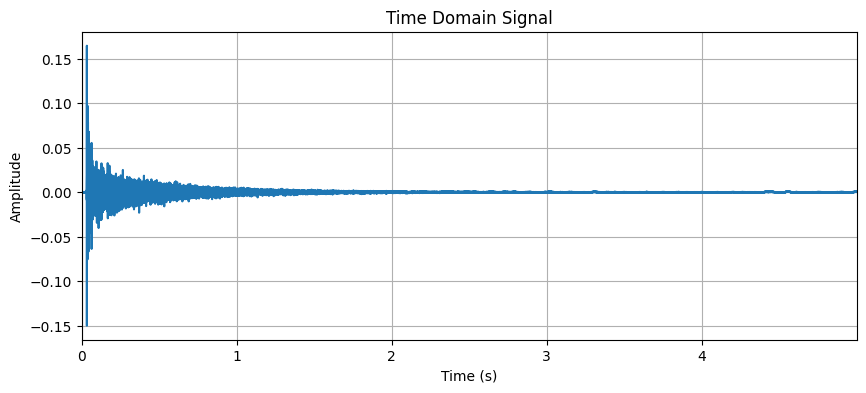

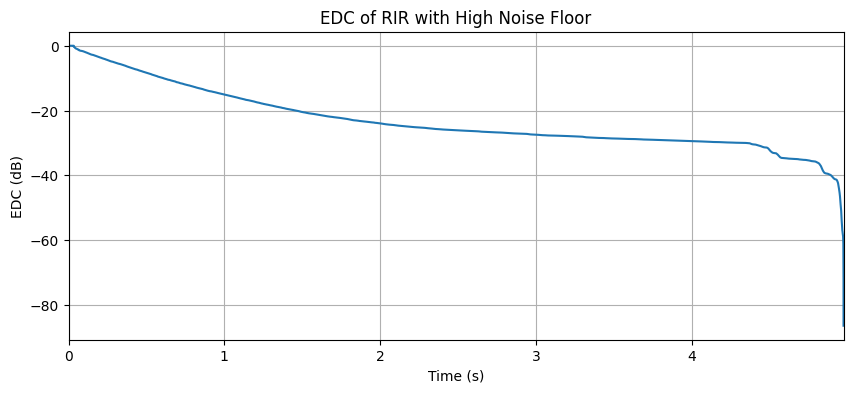

/Users/dalsag1/Aalto Dropbox/Gloria Dal Santo/aalto/workshop/vaia-25/lectures/git/VAIAWorkshop25Public/src/room_acoustics/analysis.py:109: RuntimeWarning: invalid value encountered in log10
  out = 10 * np.log10(out)


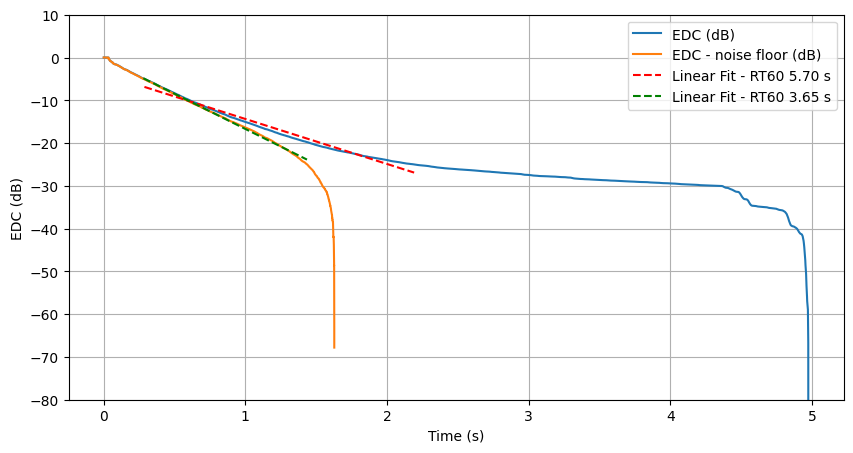

RT60 (20dB range): 5.70 s, RT60 (noise subtracted): 3.65 s


In [5]:
# --- Load RIR with High Noise Floor ---
rir_path = Path('..') / 'data' / 'P_103_Speaker.wav'
rir_2, fs_2 = audioread(str(rir_path))
ipd.display(ipd.Audio(rir_2, rate=fs_2))
plot_time_domain(rir_2, fs_2)

edc_20dB = compute_edc(rir_2, energy_norm=True)
time = np.arange(len(edc_20dB)) / fs_2

plot_time_domain(edc_20dB, fs_2, title='EDC of RIR with High Noise Floor', xlabel='Time (s)', ylabel='EDC (dB)')

# --- Estimate RT60 from Shorter Interval and  ---
# Define decay start and end dB levels - try different values 
decay_start_db, decay_end_db = -5, -25
rt60_20dB, slope_20dB, intercept_20dB, valid_range_20dB = estimate_rt60(edc_20dB, time, decay_start_db, decay_end_db)

# --- Subtract Noise Floor and Estimate RT60 ---
# Estimate the noise level from the last 50 ms of the RIR
noise_level = np.sqrt(np.mean(rir_2[-int(fs_2*0.05):]**2))
# Compute the EDC with noise floor subtracted
edc_cleaner = compute_edc(rir_2, energy_norm=True, subtract_noise=True, noise_level=noise_level)
# Recompute the time vector for the cleaned EDC
time = np.arange(len(edc_cleaner)) / fs_2
rt60_cleaner, slope_cleaner, intercept_cleaner, valid_range_cleaner = estimate_rt60(edc_cleaner, time, decay_start_db, decay_end_db)

plt.figure(figsize=(10, 5))
plt.plot(time, edc_20dB, label="EDC (dB)")
plt.plot(time, edc_cleaner, label="EDC - noise floor (dB)")
plt.plot(time[valid_range_20dB], slope_20dB * time[valid_range_20dB] + intercept_20dB, 'r--', label=f"Linear Fit - RT60 {rt60_20dB:.2f} s")
plt.plot(time[valid_range_cleaner], slope_cleaner * time[valid_range_cleaner] + intercept_cleaner, 'g--', label=f"Linear Fit - RT60 {rt60_cleaner:.2f} s")
plt.xlabel("Time (s)")
plt.ylabel("EDC (dB)")
plt.legend()
plt.grid(True)
plt.ylim(-80, 10)
plt.show()
print(f"RT60 (20dB range): {rt60_20dB:.2f} s, RT60 (noise subtracted): {rt60_cleaner:.2f} s")


#### 5 Compute the Energy Decay Relief (EDR)
If we are interested in an even finer frequency resolution, then the EDR is our way to go. 
- 5.1 Similarly to `compute_edc` complete the `compute_edr` function in `room_acoustics.analysis`. Note: you might have to modify the Schroeder backward integration function to accommodate for 2D vectors since we'll be working with STFT instead of impulse response now. To compute the spectrogram you can use `scipy.signal.spectrogram` function. 
- 5.2 Play with the `nperseg` parameter in `scipy.signal.spectrogram` to change the frequency-time resolutions. 

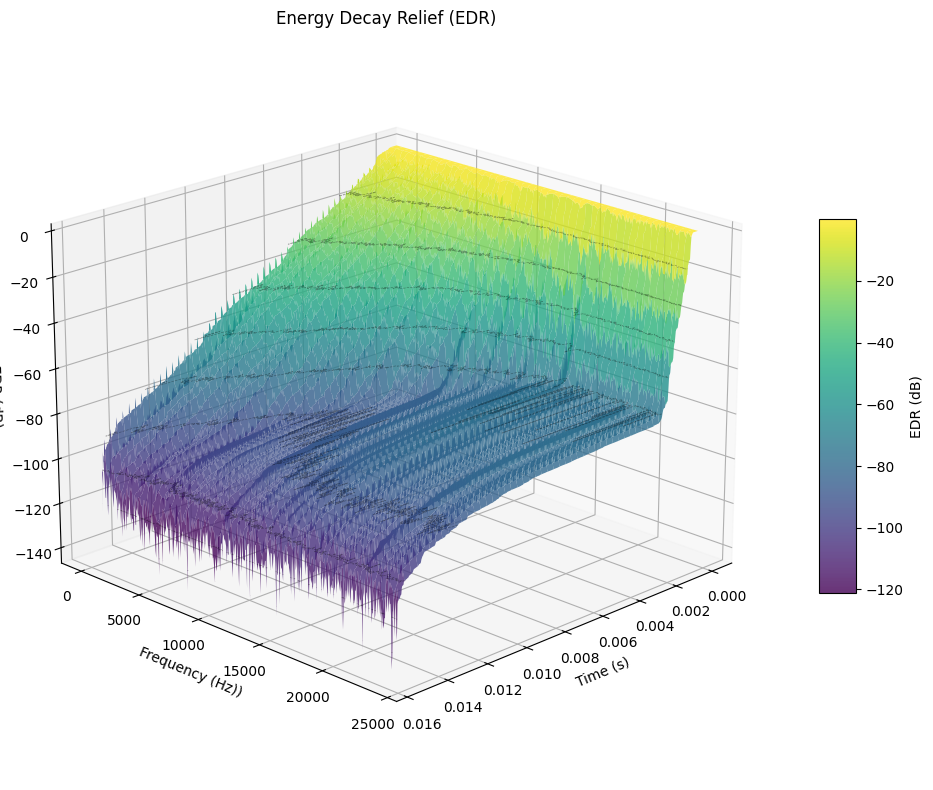

In [6]:
# --- Compute the Energy Decay Relief ---
edr = compute_edr(rir_1)

# --- Plot the Energy Decay Relief ---
# This section is already coded for you
n_freq_bands, n_time_samples = edr.shape
    
# Create time and frequency axes
time = np.arange(n_time_samples) / fs_1
freq_bands = np.arange(n_freq_bands) * (fs_1 / 2 / n_freq_bands)
T, F = np.meshgrid(time, freq_bands)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the waterfall and -10 dB contours 
surf = ax.plot_surface(T, F, edr, cmap='viridis', alpha=0.8, 
                    linewidth=0, antialiased=True)
contours = ax.contour(T, F, edr, levels=10, colors='black', alpha=0.3, linewidths=0.5)

# Set labels and title
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz))')
ax.set_zlabel('EDR (dB)')
ax.set_title('Energy Decay Relief (EDR)')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='EDR (dB)')
ax.view_init(elev=20, azim=45) # for better visibility

plt.tight_layout()
plt.show()

#### 6 Compute the Normalized Echo Density (NED) profile 
- 6.1 Complete the `normalized_echo_density` function in `room_acoustics.analysis`. 
- 6.2 Compute the NED for the two RIRs analyzed above, plus the `data.rir_0.wav` file. Note: It is recommended to remove the silence before the onset, in order to avoid noisy values at the beginning of the NED. TO do so you can use the `room_acoustics.analysis.find_onset` function. 
- 6.3 Plot the NED. How are they different from each other?
Try with different parameter configurations (one that will show you interpretable results are `window_length_ms = 100` and `use_local_avg=True`)


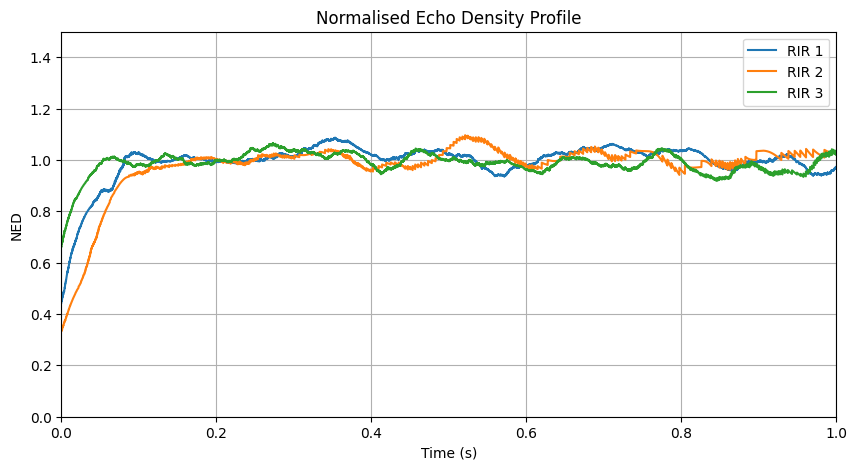

In [7]:
# --- Compute the Echo Density Profile ---
ned_1 = normalized_echo_density(
    rir_1[max(find_onset(rir_1).item(), 0):], 
    fs_1,
    window_length_ms=100, 
    use_local_avg=True
)
ned_2 = normalized_echo_density(
    rir_2[max(find_onset(rir_2).item(),0):], 
    fs_2,
    window_length_ms=100, 
    use_local_avg=True
)

# Load the third RIR and compute its NED
rir_path = Path('..') / 'data' / 'rir_0.wav'
rir_3, fs_3 = audioread(str(rir_path))
ned_3 = normalized_echo_density(
    rir_3[max(find_onset(rir_3).item(), 0):], 
    fs_3,
    window_length_ms=100, 
    use_local_avg=True
)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(ned_1))/fs_1, ned_1, label="RIR 1")
plt.plot(np.arange(len(ned_2))/fs_2, ned_2, label="RIR 2")
plt.plot(np.arange(len(ned_3))/fs_3, ned_3, label="RIR 3")
plt.xlabel("Time (s)")
plt.ylabel("NED")
plt.xlim(0, 1)
plt.ylim(0, 1.5)
plt.title("Normalised Echo Density Profile")
plt.legend()
plt.grid(True)
plt.show()
